# Getting Your Data From Yelp!

In order to make sure you are on track to completing the project, you will complete this workbook first. Below are steps that you need to take in order to make sure you have your data from yelp and are ready to analyze it. Your cohort lead will review this workbook with you the Wednesday before your project is due.    

# Part 1 - Understanding your data and question

You will be pulling data from the Yelp API to complete your analysis. The API, however, provides you with a lot of information that will not be pertinent to your analysis. You will pull data from the API and parse through it to keep only the data that you will need. In order to help you identify that information,look at the API documentation and understand what data the API will provide you. 

Identify which data fields you will want to keep for your analysis. 

https://www.yelp.com/developers/documentation/v3/get_started

# Part 2 - Create ETL pipeline for the business data from the API

## Details

Now that you know what data you need from the API, you want to write code that will execute an API call, parse those results and then insert the results into the DB.  

It is helpful to break this up into three different functions (*API call, parse results, and insert into DB*) and then you can write a function/script that pull the other three functions together. 

Let's first do this for the Business endpoint.

## Request

### Imports and Setup

In [1]:
import requests
import pandas as pd
import json
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

with open(r'C:\Users\bmcca\.secret\yelp_api.json') as f:
    keys = json.load(f)

client_id = keys['id']
yelp_key = keys['key']

### ƒ: yelp_request

 - Params: search term (eg. "wineries); location; yelp_key variable (from Imports); and changing setting to print details

In [2]:
def yelp_request(term, location, yelp_key, verbose=True):
    '''Adapted from Yelp API Lab: https://github.com/BenJMcCarty/dsc-yelp-api-lab/tree/solution'''
    
    url = 'https://api.yelp.com/v3/businesses/search'

    headers = {
            'Authorization': 'Bearer {}'.format(yelp_key),
        }

    url_params = {
                    'term': term.replace(' ', '+'),
                    'location': location.replace(' ', '+'),
                    'limit': 50
                }
    response = requests.get(url, headers=headers, params=url_params)
    
    if verbose == True:
        print(response)
        print(type(response.text))
        print(response.text[:1000])
        
    return response.json()

### Sending the request


- Un-comment the next line to run the response

In [3]:
# response = yelp_request('winery','Southern California', yelp_key)
# response.keys()

### Identifying and Exploring Keys

In [4]:
# # Identify keys

# print(response.keys())

#### Exploring the "Businesses" Key

In [5]:
# response['businesses']

In [6]:
# # Show first item w/in list of businesses

# response['businesses'][0]

In [7]:
# response['businesses'][0]['categories'][0]['alias']

In [8]:
# response['businesses'][0]['categories'][0]['title']

#### Exploring the "Total" Key

In [9]:
# response['total']

# # How many businesses are there in total for my request?

#### Exploring the "Region" Key

In [10]:
# response['region']

# # From which geographical area will my results come?

## Parse

### ƒ: parse_data

In [42]:
def parse_data(list_of_data):
    '''Adapted from Tyrell's code'''  

    # Create empty list to store results
    
    parsed_data = []
    
    # Loop through each business in the list of businesses
    # Add specific k:v pairs to a dictionary
    
    for business in list_of_data:
        if 'price' not in business:
            business['price'] = np.nan
            
            # Verify that the "price" key is in the selected business dict
            
        details = {'name': business['name'],
                     'location': ' '.join(business['location']['display_address']),
                     'business id': business['id'],
                     'alias': business['categories'][0]['alias'],
                     'title': business['categories'][0]['title'],
                     'rating': business['rating'],
                     'review_count': business['review_count'],
                     'price': business['price'],
                     'latitude': business['coordinates']['latitude'],
                     'longitude': business['coordinates']['longitude']
                    }
        # Add the new dictionary to the previous list
        
        parsed_data.append(details)
    
    # Create a DataFrame from the resulting list
    
    df_parsed_data = pd.DataFrame(parsed_data)

    
    return df_parsed_data

## Updating Requests for Pagination

### ƒ: yelp_request_offset

In [43]:
def yelp_request_offset(term, location, yelp_key, offset=0, verbose=False):
    '''Adapted from Yelp API Lab: https://github.com/BenJMcCarty/dsc-yelp-api-lab/tree/solution'''
    
    url = 'https://api.yelp.com/v3/businesses/search'

    headers = {
            'Authorization': 'Bearer {}'.format(yelp_key),
        }

    url_params = {
                    'term': term.replace(' ', '+'),
                    'location': location.replace(' ', '+'),
                    'limit': 50,
                    'offset': offset
                        }
    
    response = requests.get(url, headers=headers, params=url_params)
    
    if verbose == True:
        print(response)
        print(type(response.text))
        print(response.text[:1000])
        
    return response.json()

#### Test 1

In [44]:
# test1 = yelp_request_offset('winery', 'San Diego', yelp_key)
# test1

In [45]:
# test1.keys()

In [46]:
# test1['total']

In [47]:
# test1['businesses'][0]

## Edit and Condense

Goal: condense the details down to specific functions (perhaps one function?) to pull, clean, and save data.

While it will take some experimentation to write the functions above, once you get them working it will be best to put them in a `.py` file and then import the functions to use in a script 

# ƒ: GET BUSINESSES (ALL)

In [48]:
def get_full_data(term, location, yelp_key, file_name = 'data/wineries_raw.csv'):
    '''Requests all results from Yelp API; saves as a .csv; and returns a DataFrame.'''

    # Create a .csv to store results
    blank_df = pd.DataFrame()
    blank_df.to_csv(file_name)
    
    # Process first request to Yelp API and calculate number of pages 
    results = yelp_request_offset(term, location, yelp_key, offset=0, 
                                  verbose=False)
    num_pages = results['total']//50+1
    
    # Print out confirmation feedback
    print(f'For {term} and {location}: ')
    print(f"    Total number of results: {results['total']}.")
    print(f'    Total number of pages: {num_pages}.')
    
    # Create offset for additional results
    offset = 0

    # Retrieves remaining pages
    for num in range(num_pages-1):
        try:
            # Process API request
            results = yelp_request_offset(term, location, yelp_key,
                                          offset=offset, verbose=False)
            
            # From results, take values from "Businesses" key and save
            parsed_results = parse_data(results['businesses'])
          
            # Save resulting DF to .csv from top
            parsed_results.to_csv(file_name, mode='a', index = False)
            
            # Increase offset to move to next "page" of data
            offset += 50
            
        except:
            # If error, print where the error happens
            print(f'Error on page {num}.')
            # Then save the results so far to the .csv
            parsed_results.to_csv(file_name, mode='a', index = False)


    return parsed_results

In [49]:
get_full_data('winery', 'San Diego', yelp_key)

For winery and San Diego: 
    Total number of results: 262.
    Total number of pages: 6.


""


# Cleaning Data

# ƒ: SORT_BY_ALIASES

Identifying, Filtering for, and Saving Top 2 Aliases

In [59]:
# def sort_by_aliases(raw_data = 'data/wineries_raw.csv'):

#     # Read in businesses
#     df1 = pd.read_csv(raw_data, header = 0)

#     # Create new DF filtering alias and title columns
#     df1_alias = df1.loc[:,['alias', 'title']]

#     # Identify top 2 aliases 
#     df1_alias_count = df1_alias.groupby('alias').count().sort_values(['title'],\
#                                                             ascending=False)[:2]

#     # Note: initially tried top 3, but it returned distributors, not wineries

#     df1_alias_count.reset_index(inplace=True)
    
#     print("Top two aliases: ")
#     print(df1_alias_count)

#     # display them as a list
#     aliases_top_2 = df1_alias_count['alias'].tolist()

#     # Selecting rows based on condition and saving

#     df2 = df1[df1['alias'].isin(aliases_top_2)]

#     df2.to_csv('data/wineries_filtered_alias.csv', index = False)
#     print("Saved to 'data/wineries_filtered_alias.csv'")
    
#     return df2

In [71]:
def sort_by_aliases(raw_data = 'data/wineries_raw.csv'):

    # Read in businesses
    df1 = pd.read_csv(raw_data, header = 1)

    alias_index = df1['alias'].value_counts()[:2].index

    # Filtering rows based on condition

    df2 = df1[df1['alias'].isin(alias_index)]
    
    # Resetting index
    df2.reset_index(drop=True, inplace=True)

    df2.to_csv('data/wineries_filtered_alias.csv', index = False)

    print("Saved to 'data/wineries_filtered_alias.csv'")
    
    return df2

In [72]:
df3 = sort_by_aliases()
df3

Saved to 'data/wineries_filtered_alias.csv'


,name,location,business id,alias,title,rating,review_count,price,latitude,longitude
0,Bernardo Winery,"13330 Paseo Del Verano Norte San Diego, CA 92128",DknnpiG1p4OoM1maFshzXA,winetastingroom,Wine Tasting Room,4.5,626,$$,33.0328,-117.04646
1,Callaway Vineyard & Winery,"517 4th Ave Ste 101 San Diego, CA 92101",Cn2_bpTngghYW1ej4zreZg,winetastingroom,Wine Tasting Room,5.0,100,$$,32.7107506117294,-117.160917759246
2,Négociant Winery,"2419 El Cajon Blvd San Diego, CA 92104",Cc1sQWRWgGyMCjzX2mmMQQ,winetastingroom,Wine Tasting Room,4.5,103,$$,32.75488,-117.13828
3,San Pasqual Winery - Seaport Village,"805 W Harbor Dr San Diego, CA 92101",gMW1RvyLu90RSQAY9UrIHw,winetastingroom,Wine Tasting Room,4.5,138,$$,32.7087316452387,-117.168194991742
4,Domaine Artefact Vineyard & Winery,"15404 Highland Valley Rd Escondido, CA 92025",WqVbxY77Ag96X90LultCUw,wineries,Wineries,5.0,96,$$,33.06817,-117.0016
...,...,...,...,...,...,...,...,...,...,...
77,Roll OutThe Barrell Charity Event by Meritage,"162 S Rancho Santa Fe Rd Encinitas, CA 92024",wyLm9fIoamN-VALcu3nUVg,wineries,Wineries,4.0,1,NaN,33.037121,-117.238654
78,Licores Kentucky,Calle Puerto y 3ra S/N Col. Centro 22000 Tijua...,B7gID-M2EsdpthrTcwTNYA,wineries,Wineries,5.0,1,NaN,32.534236,-117.034976
79,Barrica 9,Av. Revolución 1265 Col. Zona Centro 22000 Tij...,HxTqmzT4G43iAKXrB3pqQg,winetastingroom,Wine Tasting Room,4.5,7,$$,32.53043,-117.0365
80,"RL Liquid Assets, Inc","5909 Sea Lion Pl Ste G Carlsbad, CA 92010",-STecUUsS69EMSE7PxwPwA,wineries,Wineries,3.0,2,NaN,33.134743,-117.248093


In [74]:
# df_saved = pd.read_csv('data/wineries_filtered_alias.csv')
# df_saved.keys()

# Part 3 -  Create ETL pipeline for the restaurant review data from the API

You've done this for the Businesses, now you need to do this for reviews. You will follow the same process, but your functions will be specific to reviews. Above you have a model of the functions you will need to write, and how to pull them together in one script. For this part, you have the process below 

## Getting Business IDs

- In order to pull the reveiws, you will need the business ids. So your first step will be to get all of the business ids from your businesses csv. 

### Open file and slice ID

1. Open data/wineries.csv
2. Slice out the 'name' and 'id' columns for each row

In [76]:
df_saved = pd.read_csv("data/wineries_filtered_alias.csv")
df_saved.reset_index(drop=True, inplace=True)

# Slice out IDs, then save them to a list

df_saved_id = df_saved['business id'].to_list()
       
len(df_saved_id)

82

## Requesting Reviews

- Write a function that takes a business id and makes a call to the API for reviews.


### ƒ: get_reviews

In [77]:
def get_reviews(business_ID, yelp_key, verbose=False):
    '''Adapted from Yelp API Lab: https://github.com/BenJMcCarty/dsc-yelp-api-lab/tree/solution'''
    
    url = 'https://api.yelp.com/v3/businesses/'+ business_ID + '/reviews'

    headers = {
            'Authorization': 'Bearer {}'.format(yelp_key),
        }

    response = requests.get(url, headers=headers)

    if verbose == True:
        print(response)
        print(type(response.text))
        print(response.text[:1000])


    return response.json()

# ƒ: Parse Reviews for final GET

In [78]:
def parse_reviews(review):
    '''Adapted from Tyrell's code'''  

    
    # Loop through each review in the list of reviews
    # Add specific k:v pairs to a dictionary      
    details = {
        'Reviewer Name': review['user']['name'],
        'Review Rating': review['rating'],
        'Review Text': review['text'],
        'Time Created': review['time_created']
        }


    # Create a DataFrame from the resulting dictionary
    
    df_parsed_reviews = pd.DataFrame.from_dict([details])
   
    return df_parsed_reviews

# ƒ: GET REVIEWS (ALL)

In [79]:
def get_all_reviews(list_of_biz_ids, yelp_key, file_name = 'data/reviews_raw.csv'):
    '''Requests all review results for given business IDs from Yelp API; \
    saves as a .csv; and returns a DataFrame.'''
    
    # Create a starter empty DataFrame and save to .csv to store data.    
    blank_df = pd.DataFrame(columns= ['Reviewer Name', 'Review Rating', 
                                      'Review Text', 'Time Created', 
                                      'id'])
    blank_df.to_csv(file_name, index = False)
        
    for i in list_of_biz_ids:
        try:
            
            # Process API request for 3 reviews per business:
            raw_reviews = get_reviews(i, yelp_key)

            for review in raw_reviews['reviews']:
                

                # From results, take values from "Businesses" key and save
                parsed_reviews = parse_reviews(review) 

                parsed_reviews['id'] = i
                
                # H2: save results to df
                parsed_reviews.to_csv(file_name, mode='a', index = False,
                                      header = False)

        except:
            # If error, print where the error happens
            print(f'Error on page {num}.')
            # Then save the results so far to the .csv
            parsed_reviews.to_csv(file_name, mode='a', index = False, 
                                  header = False)

    try:
        reviews1 = pd.read_csv(file_name)
        return reviews1
    except:
        return parsed_reviews

#### Test GET REVIEWS

In [80]:
test_all_funct = get_all_reviews(df_saved_id, yelp_key)
test_all_funct

,Reviewer Name,Review Rating,Review Text,Time Created,id
0,Patrick T.,5,Debbie and Ronnie were wonderfully attentive t...,2021-04-13 19:18:16,DknnpiG1p4OoM1maFshzXA
1,Bianca B.,5,I haven't gone to the winery since pre covid; ...,2021-02-21 15:29:51,DknnpiG1p4OoM1maFshzXA
2,stephanie l.,5,I can't believe I never been here before! It's...,2021-02-21 17:19:02,DknnpiG1p4OoM1maFshzXA
3,The Enlightened Chef S.,5,Absolutely amazing experience. We love Callawa...,2021-04-22 12:39:46,Cn2_bpTngghYW1ej4zreZg
4,Jenny F.,5,The menu I posted is their limited menu right ...,2020-06-21 12:21:35,Cn2_bpTngghYW1ej4zreZg
...,...,...,...,...,...
217,kathryn b.,5,I've purchased several times from RL Liquid as...,2017-03-11 10:21:46,-STecUUsS69EMSE7PxwPwA
218,Richard A.,1,I spoke with the sales representative over the...,2015-12-02 11:28:21,-STecUUsS69EMSE7PxwPwA
219,Hal J.,5,"This place is incredible, truly farm to table ...",2021-03-28 15:27:56,ZeiVSF1SMdVVSkiGE7qaSg
220,Lynn D.,5,You must get to Cactus Star! Although it is th...,2019-05-07 11:16:36,ZeiVSF1SMdVVSkiGE7qaSg


## Combining Functions

- Combine the functions above into a single script  

# Part 4 -  Using python and pandas, write code to answer the questions below. 

**Reviews**

Which are the 5 most reviewed businesses in your dataset?

In [81]:
df_saved.sort_values('review_count', ascending=False).head()[['name','review_count']]

,name,review_count
0,Bernardo Winery,626
7,Cordiano Winery,547
9,FruitCraft - Fermentery & Distillery,308
56,Carruth Cellars,247
5,Carruth Cellars Wine Garden,196


What is the highest rating received in your data set and how many businesses have that rating?

In [82]:
max_rating = df_saved['rating'].max()

df_saved[df_saved['rating']== max_rating].shape

(31, 10)

In [83]:
sns.__version__

'0.11.0'

In [84]:
df_saved

,name,location,business id,alias,title,rating,review_count,price,latitude,longitude
0,Bernardo Winery,"13330 Paseo Del Verano Norte San Diego, CA 92128",DknnpiG1p4OoM1maFshzXA,winetastingroom,Wine Tasting Room,4.5,626,$$,33.032800,-117.046460
1,Callaway Vineyard & Winery,"517 4th Ave Ste 101 San Diego, CA 92101",Cn2_bpTngghYW1ej4zreZg,winetastingroom,Wine Tasting Room,5.0,100,$$,32.710751,-117.160918
2,Négociant Winery,"2419 El Cajon Blvd San Diego, CA 92104",Cc1sQWRWgGyMCjzX2mmMQQ,winetastingroom,Wine Tasting Room,4.5,103,$$,32.754880,-117.138280
3,San Pasqual Winery - Seaport Village,"805 W Harbor Dr San Diego, CA 92101",gMW1RvyLu90RSQAY9UrIHw,winetastingroom,Wine Tasting Room,4.5,138,$$,32.708732,-117.168195
4,Domaine Artefact Vineyard & Winery,"15404 Highland Valley Rd Escondido, CA 92025",WqVbxY77Ag96X90LultCUw,wineries,Wineries,5.0,96,$$,33.068170,-117.001600
...,...,...,...,...,...,...,...,...,...,...
77,Roll OutThe Barrell Charity Event by Meritage,"162 S Rancho Santa Fe Rd Encinitas, CA 92024",wyLm9fIoamN-VALcu3nUVg,wineries,Wineries,4.0,1,NaN,33.037121,-117.238654
78,Licores Kentucky,Calle Puerto y 3ra S/N Col. Centro 22000 Tijua...,B7gID-M2EsdpthrTcwTNYA,wineries,Wineries,5.0,1,NaN,32.534236,-117.034976
79,Barrica 9,Av. Revolución 1265 Col. Zona Centro 22000 Tij...,HxTqmzT4G43iAKXrB3pqQg,winetastingroom,Wine Tasting Room,4.5,7,$$,32.530430,-117.036500
80,"RL Liquid Assets, Inc","5909 Sea Lion Pl Ste G Carlsbad, CA 92010",-STecUUsS69EMSE7PxwPwA,wineries,Wineries,3.0,2,NaN,33.134743,-117.248093


# Converting Price to Int

In [85]:
df_saved['price'].value_counts(dropna=False)

$$     53
NaN    25
$       3
$$$     1
Name: price, dtype: int64

In [86]:
df_saved['price_converted'] = df_saved['price'].map({np.nan:0, '$':1, '$$':2, '$$$':3})

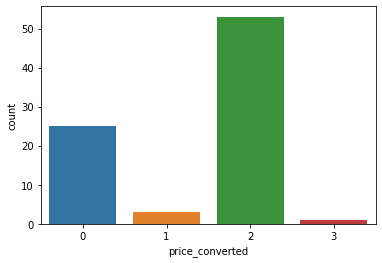

In [87]:
sns.countplot(x= 'price_converted', data=df_saved);

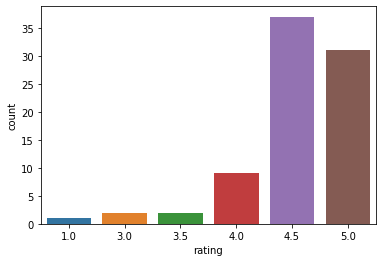

In [88]:
sns.countplot(x= 'rating',data=df_saved);

>- `hue` parameter - seaborn

What percentage of businesses have a rating greater than or  4.5?

In [89]:
df_total_high = df_saved[df_saved['rating'] >= 4.5].shape[0]
df_total_high / df_saved.shape[0]

0.8292682926829268

What percentage of businesses have a rating less than 3?

In [90]:
df_total_low = df_saved[df_saved['rating'] < 3].shape[0]
df_total_low

1

In [91]:
df_total_low / df_saved.shape[0]

0.012195121951219513

---

**Pricing**

What percentage of your businesses have a price label of one dollar sign? Two dollar signs? Three dollar signs? No dollar signs?

In [92]:
df_total_zero = df_saved[df_saved['price_converted'] == 0].shape[0]
print(df_total_zero / df_saved.shape[0])
df_total_one = df_saved[df_saved['price_converted'] == 1].shape[0]
print(df_total_one / df_saved.shape[0])
df_total_two = df_saved[df_saved['price_converted'] == 2].shape[0]
print(df_total_two / df_saved.shape[0])
df_total_three = df_saved[df_saved['price_converted'] == 3].shape[0]
print(df_total_three / df_saved.shape[0])

0.3048780487804878
0.036585365853658534
0.6463414634146342
0.012195121951219513


---

**Returing Reviews**

Return the text of the reviews for the most reviewed business. 

In [93]:
df_saved.keys()

Index(['name', 'location', 'business id', 'alias', 'title', 'rating',
       'review_count', 'price', 'latitude', 'longitude', 'price_converted'],
      dtype='object')

In [99]:
max_reviewed = df_saved['review_count'].max()
most_reviewed_id = df_saved[df_saved['review_count'] == max_reviewed]['business id']
most_reviewed_id
# test_all_funct[test_all_funct['business id'] == 'DknnpiG1p4OoM1maFshzXA']


0    DknnpiG1p4OoM1maFshzXA
Name: business id, dtype: object

In [ ]:
test_all_funct.keys()

Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews. 

In [ ]:
top_b = df_saved[df_saved['rating'] == max_rating]
max_counts = df_saved['review_count'].max()
top_num_reviews_top_b = top_b['review_count'].max()
top_b[top_b['review_count'] == top_num_reviews_top_b]

Find the lowest rated business and return text of the most recent review.  If multiple business have the same rating, select the business with the least reviews. 

In [95]:
min_b = df_saved['rating'].min()
min_b = df_saved[df_saved['rating'] == min_b]
min_counts = df_saved['review_count'].min()
min_num_reviews_min_b = min_b['review_count'].min()
min_b[min_b['review_count'] == min_num_reviews_min_b]

,name,location,business id,alias,title,rating,review_count,price,latitude,longitude,price_converted
69,I Love Wine,"2420 Grand Ave Ste B2 San Diego, CA 91902",fT9ysnQvYXw-RUD4GNodEQ,wineries,Wineries,1.0,1,NaN,32.801342,-117.225365,0


# Reference help

###  Pagination

Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retriving 50 at a time. Processes such as these are often refered to as pagination.

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. 

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and APIs can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

***Below is sample code that you can use to help you deal with the pagination parameter and bring all of the functions together.***


***Also, something might cause your code to break while it is running. You don't want to constantly repull the same data when this happens, so you should insert the data into the database as you call and parse it, not after you have all of the data***


In [ ]:
# create a variable  to keep track of which result you are in. 
cur = 0

#set up a while loop to go through and grab the result 
while cur < num and cur < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    #make your API call with the new offset number
    results = yelp_call(url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    db_insert(parsed_results)
    #increment the counter by 50 to move on to the next results
    cur += 20